# Predicción de morosidad de crédito con modelos de clasificación.
Dataset: GiveMeSomeCredit (Kaggle)

#1. Carga de datos

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo de los gráficos
sns.set(style="whitegrid")

# Carga del dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('cs-training.csv', index_col=0)

# Dimensiones del dataset
print("Filas y columnas:", df.shape)
df.info()

Saving cs-training.csv to cs-training.csv
Filas y columnas: (150000, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  

#2. Limpieza de datos

In [2]:
# Estadísticos descriptivos
df.describe().T.sort_values("max", ascending=False)

,count,mean,std,min,25%,50%,75%,max
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfDependents,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0


In [3]:
# % de nulos
df.isnull().mean().sort_values(ascending=False) * 100

,0
MonthlyIncome,19.820667
NumberOfDependents,2.616000
SeriousDlqin2yrs,0.000000
age,0.000000
RevolvingUtilizationOfUnsecuredLines,0.000000
DebtRatio,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0.000000
NumberOfOpenCreditLinesAndLoans,0.000000
NumberOfTimes90DaysLate,0.000000
NumberRealEstateLoansOrLines,0.000000


In [4]:
# MonthlyIncome - Imputación de nulos y winsorizado en $20.000 usd/mes
df['MonthlyIncome']=df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['MonthlyIncome'] = df['MonthlyIncome'].clip(upper=20000)

In [5]:
# RevolvingUtilizationOfUnsecuredLines - Truncamiento a 1 del %
df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1)


In [6]:
# DebtRatio - Truncamiento a 1 del %
df['DebtRatio'] = df['DebtRatio'].clip(upper=1)

In [7]:
# Age - Eliminar observaciones para menores de edad
df = df[df['age'] >= 18]

#3. Análisis exploratorio (EDA)

In [8]:
# Distribución de la variable objetivo (1 es default)
df['SeriousDlqin2yrs'].value_counts(normalize=True) * 100

,proportion
SeriousDlqin2yrs,
0,93.315955
1,6.684045


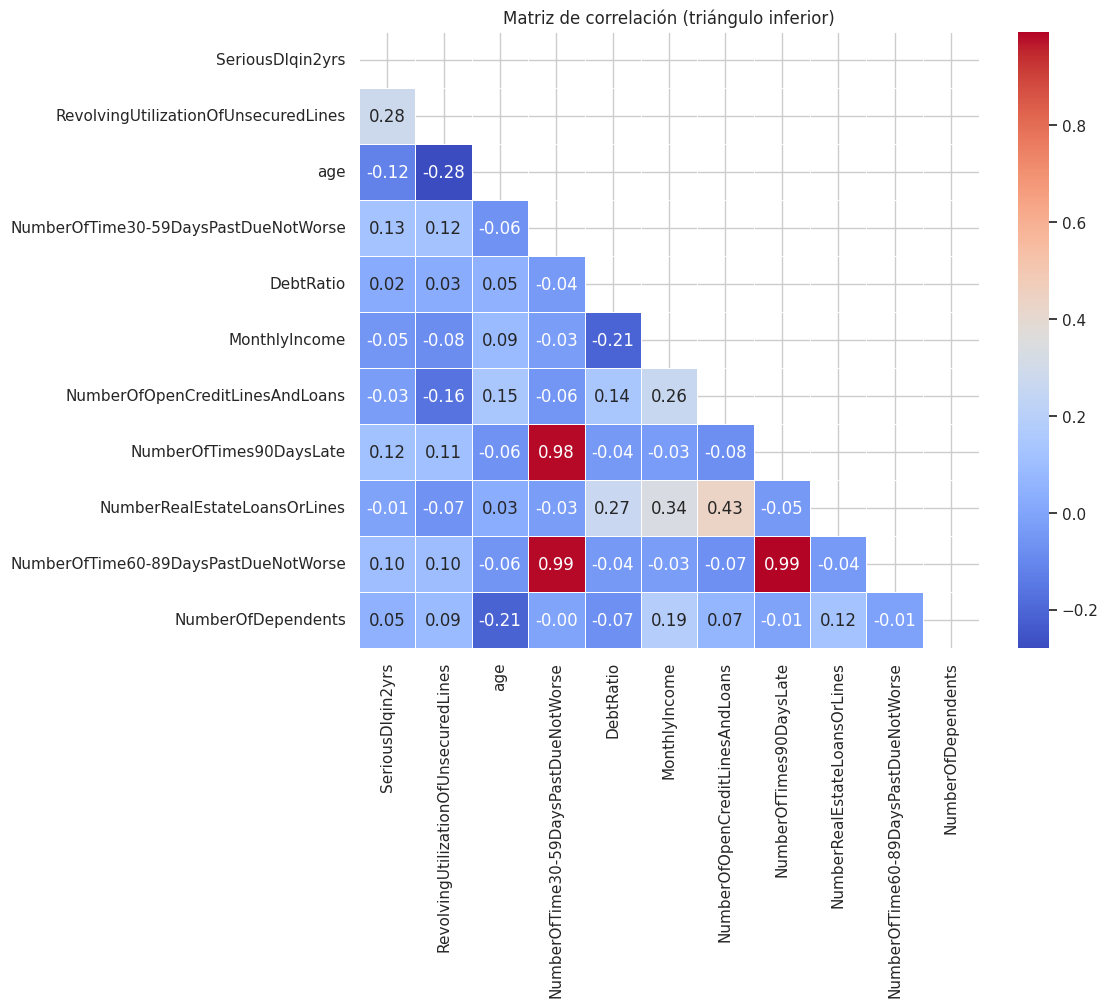

In [9]:
# Matriz de correlación
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación (triángulo inferior)")
plt.show()

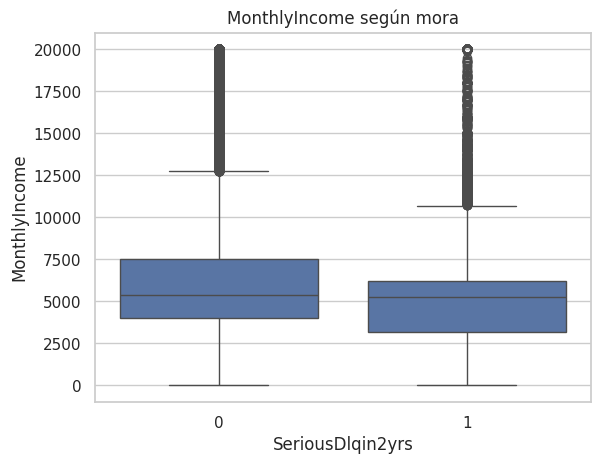

In [10]:
# Ingreso mensual según mora
sns.boxplot(x='SeriousDlqin2yrs', y='MonthlyIncome', data=df)
plt.title("MonthlyIncome según mora")

plt.show()

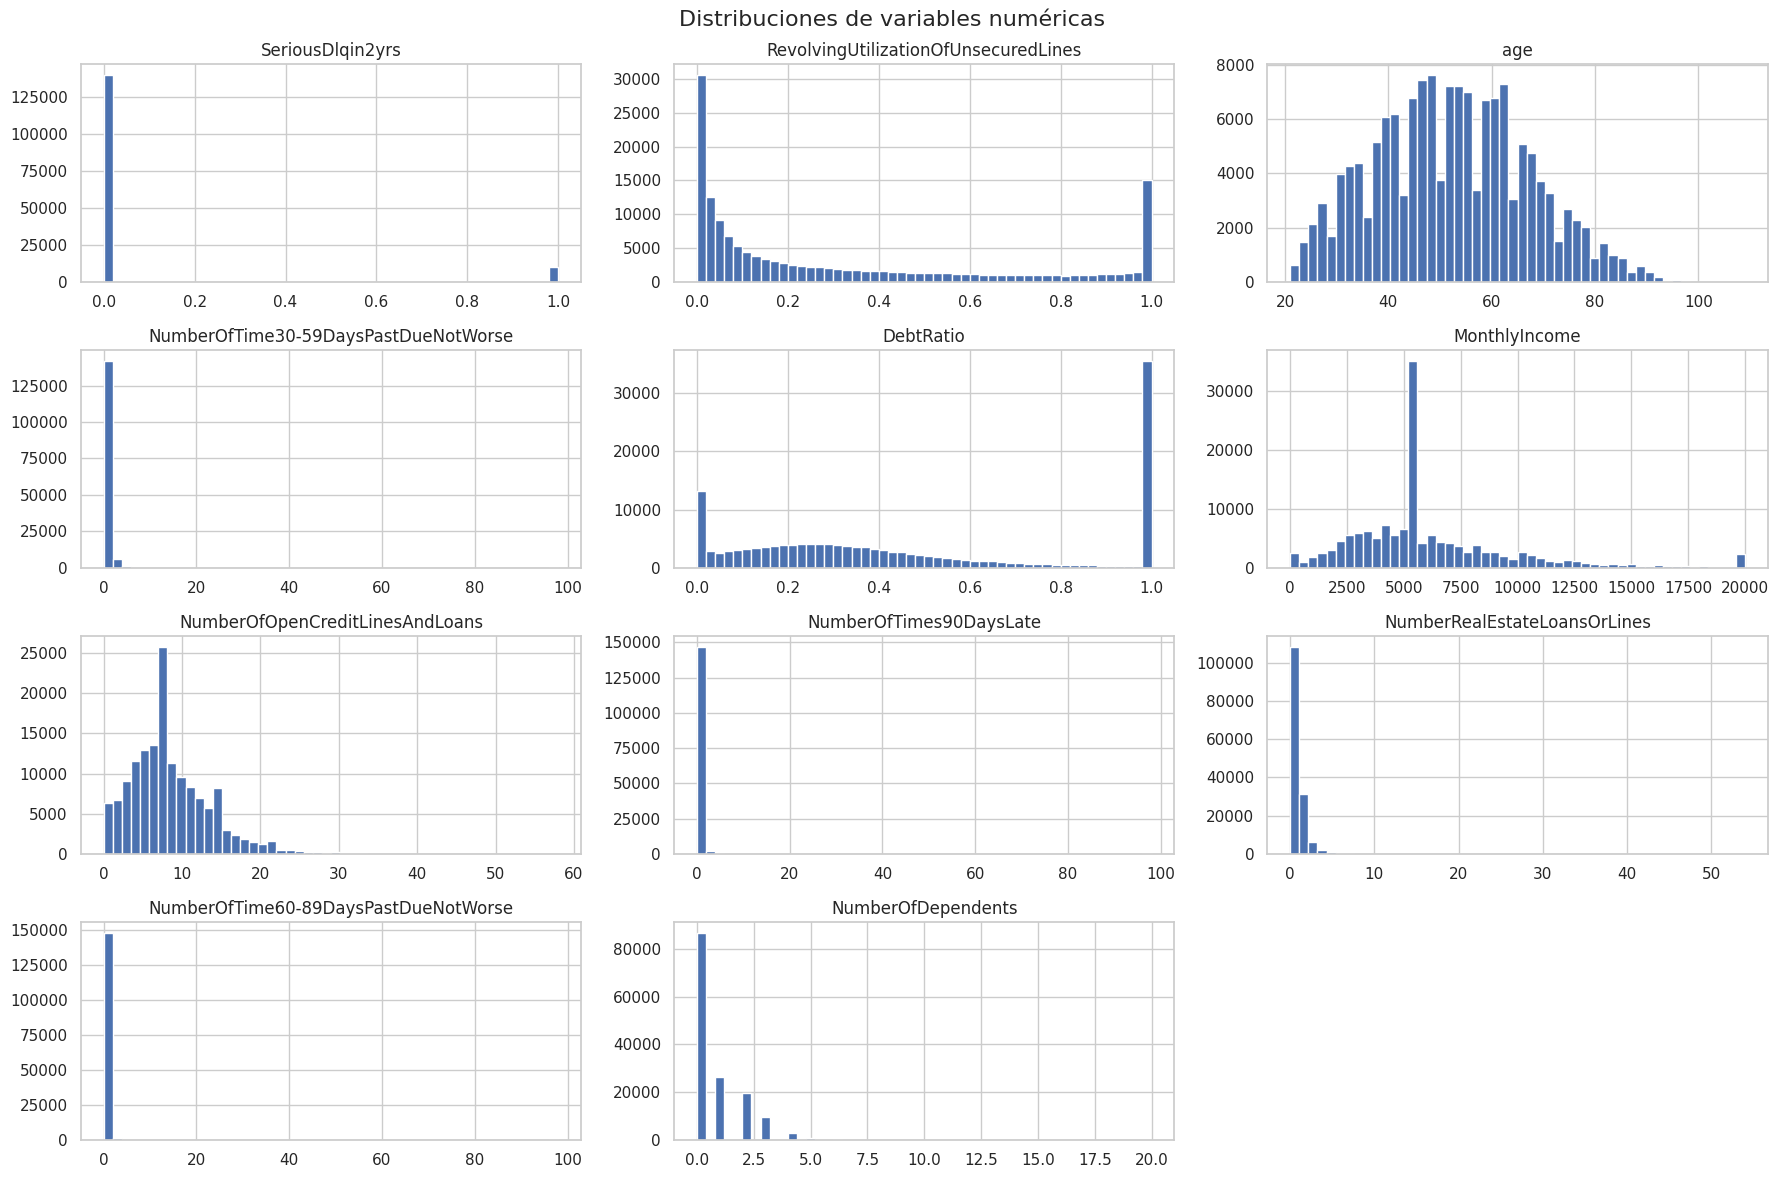

In [11]:
# Histogramas
df.hist(bins=50, figsize=(18, 12))
plt.suptitle("Distribuciones de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()

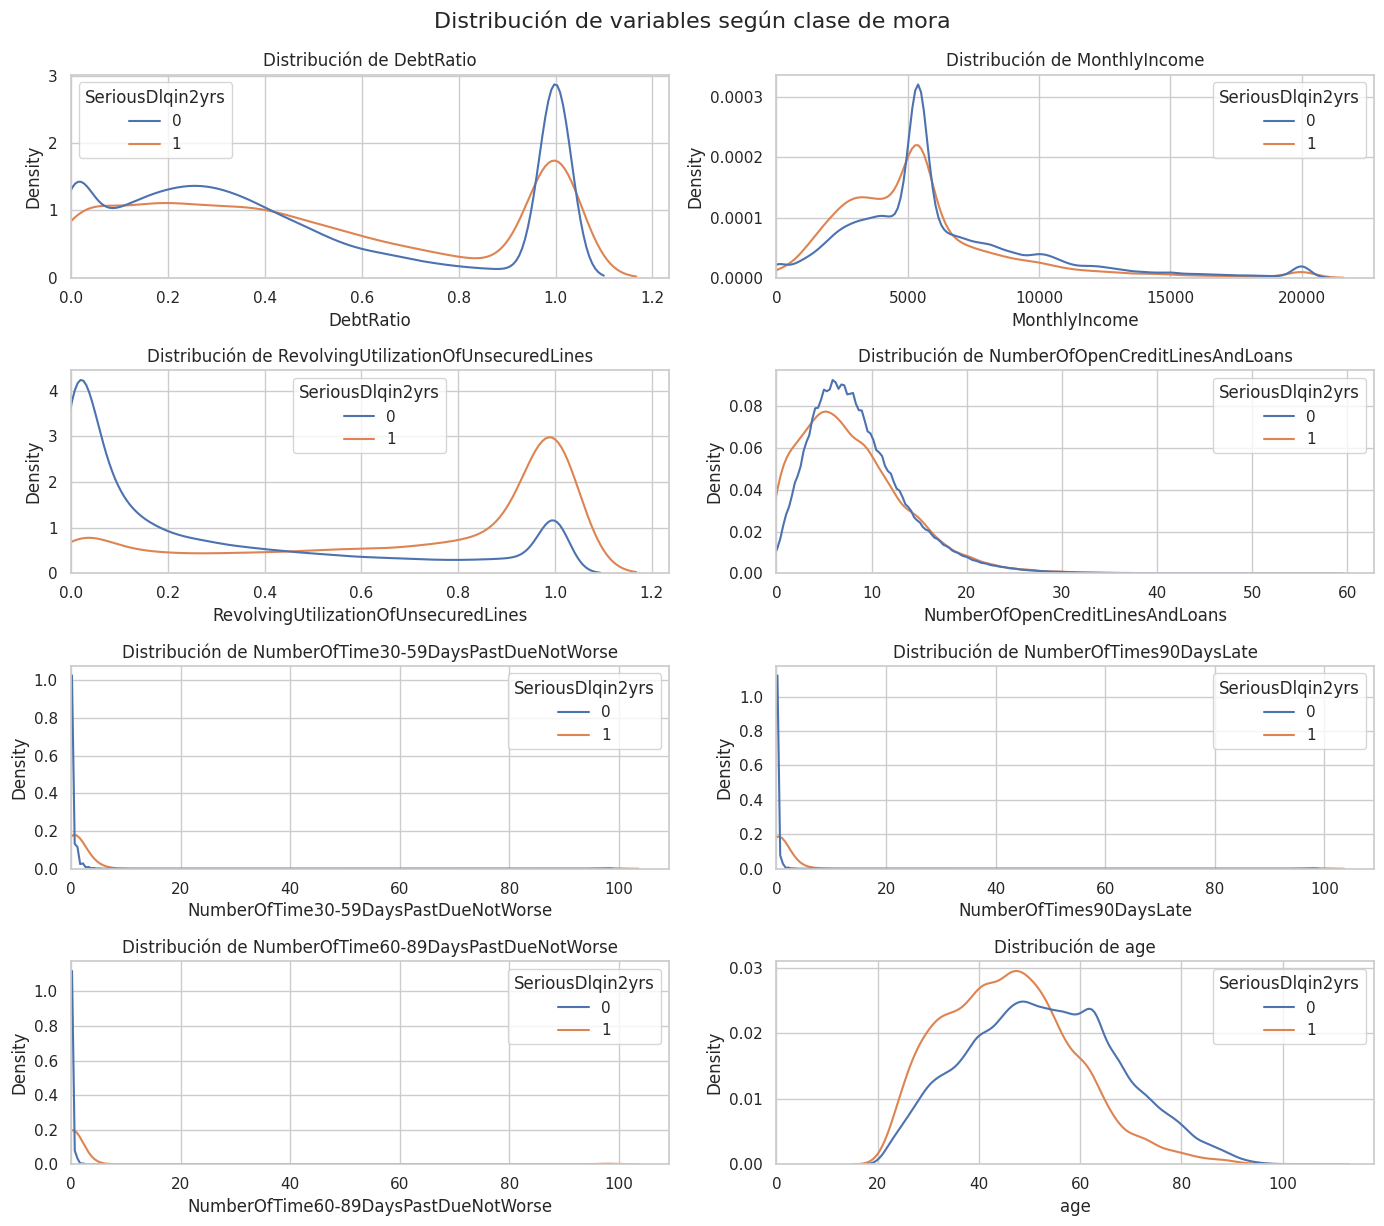

In [12]:
# Graficamos la distribución (KDE) de variables clave, separando entre morosos (1) y no morosos (0).
# Esto ayuda a detectar qué variables podrían ser útiles para predecir la probabilidad de default.

vars_a_graficar = [
    'DebtRatio',
    'MonthlyIncome',
    'RevolvingUtilizationOfUnsecuredLines',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'age'
]

# Seteo de figura
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))  # 4 filas x 2 columnas
axes = axes.flatten()  # lo convierto en un array plano para iterar fácil

for i, col in enumerate(vars_a_graficar):
    sns.kdeplot(data=df, x=col, hue='SeriousDlqin2yrs', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlim(left=0)

plt.tight_layout()
plt.suptitle('Distribución de variables según clase de mora', fontsize=16, y=1.02)
plt.show()

#4. Preparación de variables

In [15]:
# División en train y test - con estratificado.
features = [
    'DebtRatio',
    'MonthlyIncome',
    'RevolvingUtilizationOfUnsecuredLines',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'NumberOfOpenCreditLinesAndLoans',
    'age'
]

X = df[features]
y = df['SeriousDlqin2yrs']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [16]:
# Estandarización de variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#5. Modelado (Regresión logística)

In [17]:
# Modelo logit con mayor peso a la clase 1 (default)
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

#6. Evaluación del modelo

In [18]:
# Matriz de confusión
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, RocCurveDisplay
)
y_pred  = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:,1]

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion matrix:
[[21380  6615]
 [  508  1497]]



Classification report:
              precision    recall  f1-score   support

           0      0.977     0.764     0.857     27995
           1      0.185     0.747     0.296      2005

    accuracy                          0.763     30000
   macro avg      0.581     0.755     0.577     30000
weighted avg      0.924     0.763     0.820     30000

AUC: 0.837


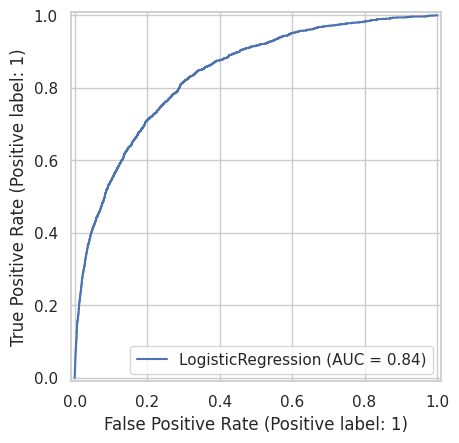

In [19]:
# Evaluación y curva ROC
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

print("AUC:", round(roc_auc_score(y_test, y_proba), 4))

# Curva ROC rápida
RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test)
plt.show()

#7. Interpretación con SHAP

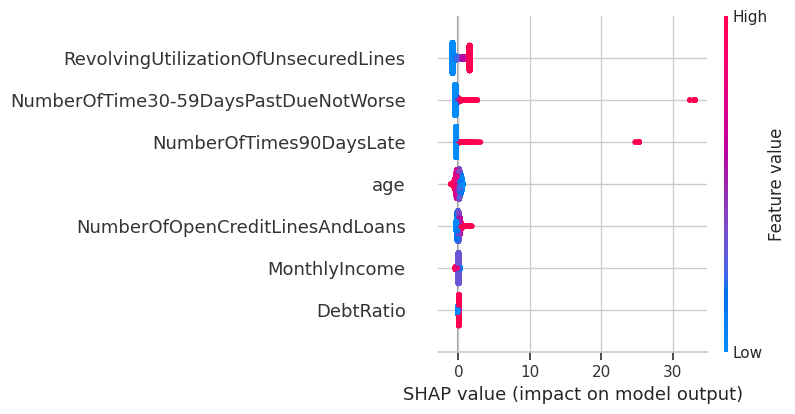

In [20]:
# Interpretación global

import shap

explainer = shap.Explainer(log_reg, X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

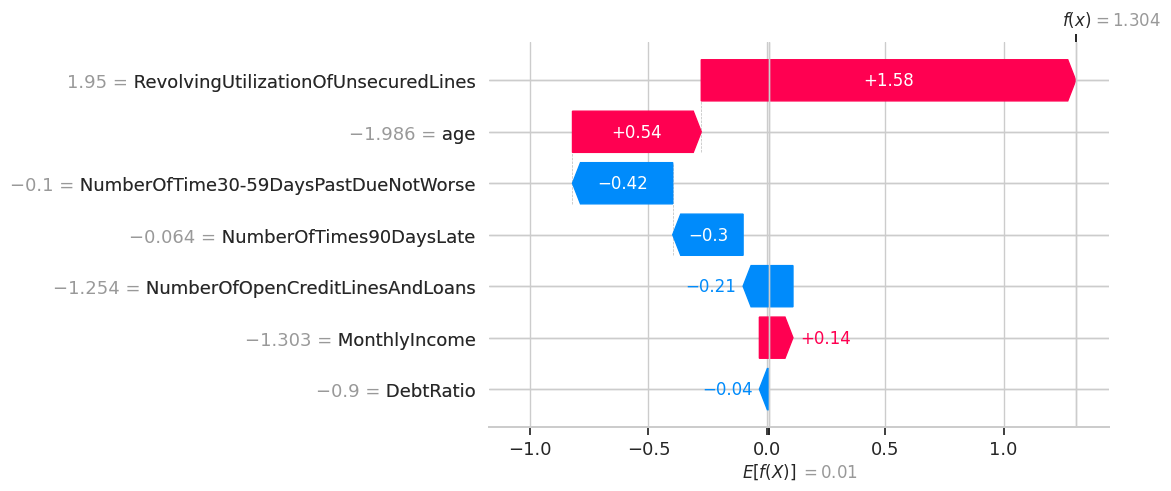

0.7865074067869517


In [31]:
# Interpretación individual
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
explainer = shap.Explainer(log_reg, X_train_scaled)
shap_values = explainer(X_test_scaled_df)

# Individuo 500, por ejemplo
shap.plots.waterfall(shap_values[500])
proba = 1 / (1 + np.exp(-1.304))
print(proba)